In [1]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

2023-05-15 17:35:25.260335: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.set_visible_devices([], 'GPU')

2023-05-15 17:35:26.832795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-15 17:35:26.864914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-15 17:35:26.865080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
with open('../dataset_configs/benchmark.json', 'r') as file:
    config = json.load(file)

In [4]:
# import data
xt = np.load('../x_train.npy')
xt /= np.max(xt, axis=1, keepdims=True)
xv = np.load('../x_val.npy')
xv /= np.max(xv, axis=1, keepdims=True)
xtest = np.load('../x_test.npy')#[::3]
xtest /= np.max(xtest, axis=1, keepdims=True)
xp = xtest[::9]

yt = np.load('../y_train.npy')
yv = np.load('../y_val.npy')
ytest = np.load('../y_test.npy')
yp = ytest[::9]

classes = np.unique(ytest).size
yt = tf.one_hot(yt, classes)
yv = tf.one_hot(yv, classes)
ytest = tf.one_hot(ytest, classes)

2023-05-15 17:35:27.561632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Select the best performing models per architecture

### Model weights available here:
https://figshare.com/articles/software/Trained_network_weights/21602943

In [5]:
cnn2 = tf.keras.models.load_model('../model_weights/cnn2-2.h5')
cnn3 = tf.keras.models.load_model('../model_weights/cnn3-3.h5')
cnn6 = tf.keras.models.load_model('../model_weights/cnn6-0.h5')
vgg = tf.keras.models.load_model('../model_weights/vgg-4.h5')
resnet = tf.keras.models.load_model('../model_weights/resnet-2.h5')
inc3 = tf.keras.models.load_model('../model_weights/inc3-0.h5')
inc6 = tf.keras.models.load_model('../model_weights/inc6-1.h5')

In [6]:
model_list = [cnn2, cnn3, cnn6, vgg, resnet, inc3, inc6]

In [7]:
_ = [model.evaluate(xtest, ytest, batch_size=16, verbose=2) for model in model_list]

282/282 - 3s - loss: 0.0255 - accuracy: 0.9931 - 3s/epoch - 9ms/step
282/282 - 4s - loss: 0.0202 - accuracy: 0.9944 - 4s/epoch - 15ms/step
282/282 - 11s - loss: 0.0041 - accuracy: 0.9987 - 11s/epoch - 39ms/step
282/282 - 2s - loss: 0.0124 - accuracy: 0.9964 - 2s/epoch - 7ms/step
282/282 - 25s - loss: 0.0095 - accuracy: 0.9956 - 25s/epoch - 90ms/step
282/282 - 7s - loss: 0.0109 - accuracy: 0.9973 - 7s/epoch - 25ms/step
282/282 - 12s - loss: 0.0066 - accuracy: 0.9978 - 12s/epoch - 42ms/step


In [8]:
preds = [model.predict(xtest, batch_size=16) for model in model_list]

282/282 [==============================] - 12s 42ms/step


In [9]:
ye = np.argmax(ytest, axis=1)

In [10]:
def get_misclassification_pairs(pred_array, label_array):
    idx_list = np.where(
        np.argmax(pred_array, axis=1) != label_array
    )[0]
    true_label_list = label_array[idx_list]
    prediction_list = np.argmax(pred_array, axis=1)[idx_list]
    stack = np.hstack([true_label_list[:,None],prediction_list[:,None]])
    return np.sort(stack, axis=1)

### Output the misclassifications pairs per model

In [11]:
[np.unique(get_misclassification_pairs(p, ye), axis=0, return_counts=True) for p in preds]

[(array([[  8, 318],
         [ 15, 482],
         [ 39, 305],
         [ 59, 167],
         [123, 247],
         [164, 281],
         [206, 403],
         [219, 347],
         [246, 382],
         [336, 421],
         [428, 468]]),
  array([3, 3, 2, 3, 1, 6, 6, 3, 1, 1, 2])),
 (array([[  8, 318],
         [ 15, 482],
         [ 39, 305],
         [ 59, 167],
         [164, 281],
         [206, 403],
         [219, 347],
         [246, 382],
         [336, 421],
         [428, 468]]),
  array([3, 3, 1, 3, 6, 3, 3, 1, 1, 1])),
 (array([[  8, 318],
         [164, 281],
         [206, 403]]),
  array([3, 2, 1])),
 (array([[  8, 318],
         [ 15, 482],
         [ 39, 305],
         [133, 358],
         [164, 281],
         [206, 403],
         [219, 347],
         [222, 482],
         [246, 382]]),
  array([3, 3, 1, 1, 1, 2, 3, 1, 1])),
 (array([[  8, 318],
         [ 15, 482],
         [ 59, 167],
         [ 94, 215],
         [164, 281],
         [219, 347]]),
  array([3, 3, 1, 3, 7, 

## For patterns with misclassifications: how many peaks are present?

In [12]:
mis_class = [np.unique(get_misclassification_pairs(p, ye).ravel(), axis=0).tolist() for p in preds]

In [13]:
m = set([])
for mc in mis_class:
    m = m | set(mc)
m = list(m)

In [14]:
np.unique(np.array([len(config['spectra'][str(i)]['peak_positions']) for i in m]), return_counts=True)

(array([2, 3, 4]), array([21,  4,  2]))

### Only misclassifications for patterns with 4 or less peaks

In [15]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'ps.fonttype': 42})

# Misclassification case 1: Overlooking Minor Peaks

Classes 246 and 382 cause misclassifications for many models

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


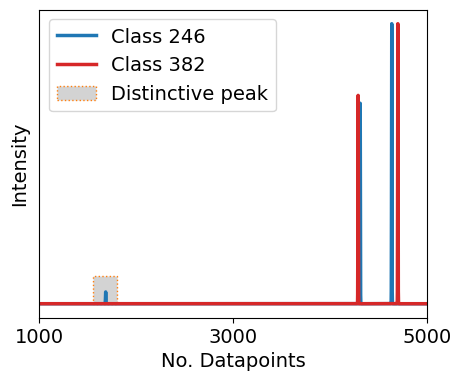

In [16]:
plt.figure(figsize=(5,4))
plt.fill([1550, 1550, 1800, 1800], [0., .1, .1, 0.], facecolor='lightgrey', 
         edgecolor='C1', ls='dotted', label='Distinctive peak')
plt.plot(xp[246], lw=2.5, label='Class 246', c='C0')
plt.plot(xp[382], lw=2.5, label='Class 382', c='C3')
h, l = plt.gca().get_legend_handles_labels()
h.append(h.pop(0))
l.append(l.pop(0))
plt.legend(h,l)
plt.xticks([1000,3000,5000])
plt.xlabel('No. Datapoints')
plt.ylabel('Intensity')
plt.xlim(1000,5000)
plt.yticks([])
plt.savefig('../figures/minor_peak_overlook.eps', bbox_inches='tight')
#plt.show()

# Misclassification case 2: Overlapping peak positions

In [17]:
from matplotlib.gridspec import GridSpec

In [18]:
cl1 = 8
cl2 = 318

In [19]:
train_pos = np.argmax(xt[:,3000:3500], axis=1)+3000
train_hi = np.max(xt[:,3000:3500], axis=1)
val_pos = np.argmax(xv[:,3000:3500], axis=1)+3000
val_hi = np.max(xv[:,3000:3500], axis=1)
test_pos = np.argmax(xtest[:,3000:3500], axis=1)+3000
test_hi = np.max(xtest[:,3000:3500], axis=1)

In [20]:
df = pd.DataFrame()
df['pos'] = np.hstack([train_pos[cl1*50:(cl1+1)*50],train_pos[cl2*50:(cl2+1)*50]])
df['hi'] = np.hstack([train_hi[cl1*50:(cl1+1)*50],train_hi[cl2*50:(cl2+1)*50]])
df['cl'] = np.repeat(np.array([0,1]), 50)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


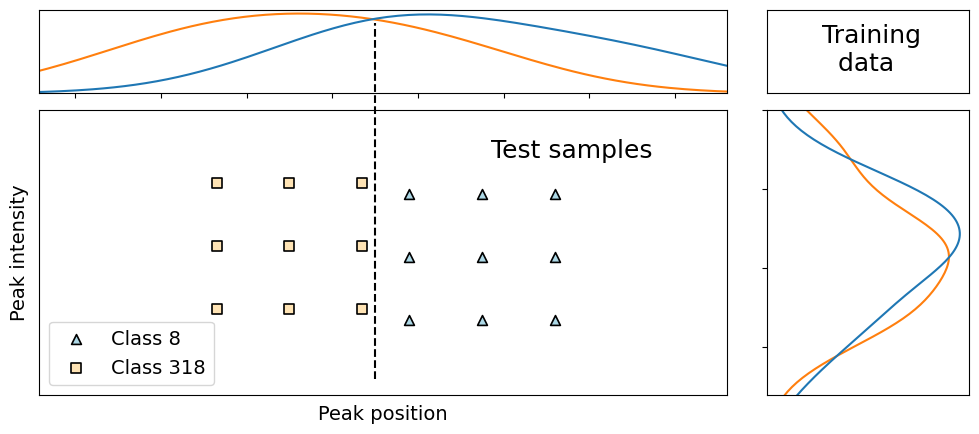

In [21]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'ps.fonttype': 42})

fig = plt.figure(figsize=(12,5))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])
ax_marg_top = fig.add_subplot(gs[0,3])

ax_joint.scatter(test_pos[cl1*9:(cl1+1)*9],test_hi[cl1*9:(cl1+1)*9], s=50, 
            edgecolors='black', marker='^', lw=1.2, c='lightblue', label='Class 8')
ax_joint.scatter(test_pos[cl2*9:(cl2+1)*9],test_hi[cl2*9:(cl2+1)*9], s=50, 
            edgecolors='black', marker='s', lw=1.2, c='moccasin', label='Class 318')
#ax_joint.scatter(train_pos[cl1*50:(cl1+1)*50],train_hi[cl1*50:(cl1+1)*50])
#ax_joint.scatter(train_pos[cl2*50:(cl2+1)*50],train_hi[cl2*50:(cl2+1)*50])
sns.kdeplot(data=df, x='pos', hue='cl', ax=ax_marg_x, fill=False, bw_adjust=2.)
sns.kdeplot(data=df, y='hi', hue='cl', ax=ax_marg_y, fill=False, bw_adjust=1.2)
# remove labels + legend
ax_marg_x.set_xlabel('')
ax_marg_x.get_legend().remove()
ax_marg_x.set_yticks([])
ax_marg_y.set_ylabel('')
ax_marg_y.get_legend().remove()
ax_marg_y.set_xticks([])
ax_marg_top.text(0.27,0.27,'Training\n  data', fontsize=18)
ax_marg_top.set_xticks([])
ax_marg_top.set_yticks([])
ax_joint.text(3360,0.92,'Test samples', fontsize=18)
# match lims of train and test data
xlim = ax_marg_x.get_xlim()
xlim = (xlim[0]+80,xlim[1]-80)
ax_marg_x.set_xlim(xlim[0]-3,xlim[1]-3)
#ylim = ax_marg_y.get_ylim()
ylim = (0.77,0.95)
ax_marg_y.set_ylim(ylim)
ax_joint.set_xlim(xlim)
ax_joint.set_ylim(ylim)

ax_joint.set_yticks([])
ax_joint.set_xticks([])
ax_joint.legend(loc=3)

# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Peak position')
ax_joint.set_ylabel('Peak intensity')

transFigure = fig.transFigure.inverted()

coord1 = transFigure.transform(ax_joint.transData.transform([3333,0.78]))
coord2 = transFigure.transform(ax_marg_x.transData.transform([3330,0.0045]))

line = matplotlib.lines.Line2D((coord1[0],coord2[0]),(coord1[1],coord2[1]),
                               transform=fig.transFigure, color='black', linestyle='--')
fig.lines = line,

# Set labels on marginals
ax_marg_y.set_xlabel('')#('Train intensity')
ax_marg_x.set_ylabel('')#('Train pos.')
plt.savefig('../figures/position_overlap.eps', bbox_inches='tight')
#plt.show()

### Misclassification case 3: Overlapping peak intensities

In [22]:
print(config["spectra"]["164"])
print(config["spectra"]["281"])

{'peak_positions': [2774, 3876], 'peak_heights': [0.24, 1.0]}
{'peak_positions': [2780, 3924], 'peak_heights': [0.273, 1.0]}


In [23]:
train_pos = np.argmax(xt[:,:3000], axis=1)
train_hi = np.max(xt[:,:3000], axis=1)
test_pos = np.argmax(xtest[:,:3000], axis=1)
test_hi = np.max(xtest[:,:3000], axis=1)

In [24]:
cl1 = 164
cl2 = 281

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


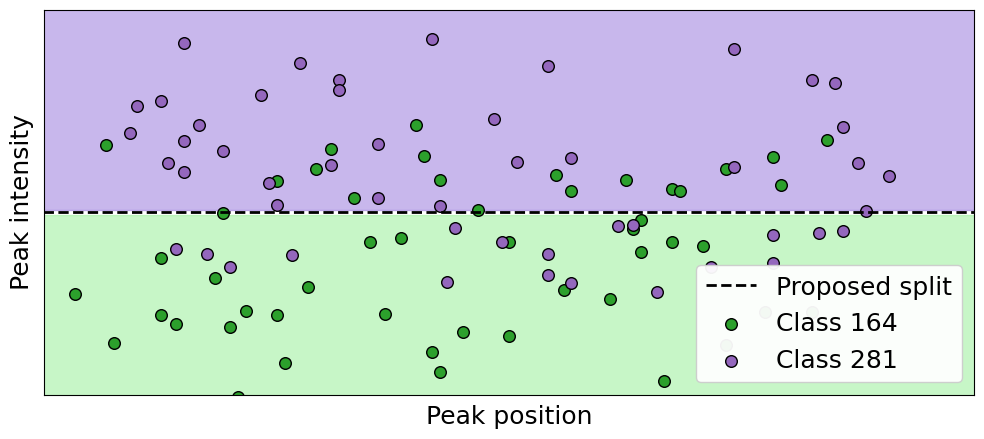

In [25]:
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'ps.fonttype': 42})

plt.figure(figsize=(12,5))
#plt.grid()

plt.fill([2700,2860,2860,2700], [.261,.261,.35,.35], alpha=.5, color='mediumpurple')
plt.fill([2700,2860,2860,2700], [.259,.259,.18,.18], alpha=.5, color='lightgreen')

plt.plot([2700, 2860], [.26,.26], linestyle='dashed', c='black', lw=2, label='Proposed split')
plt.scatter(train_pos[cl1*50:(cl1+1)*50], train_hi[cl1*50:(cl1+1)*50], s=70, 
            edgecolors='black', c='C2', label='Class 164')
plt.scatter(train_pos[cl2*50:(cl2+1)*50], train_hi[cl2*50:(cl2+1)*50], s=70, 
            edgecolors='black', c='C4', label='Class 281')
plt.ylim(.19, .338)
plt.xlim(2720, 2840)
plt.legend(framealpha=.95, loc=4)
ax = plt.gca()
ax.set_axisbelow(True)
plt.xticks([])
plt.yticks([])
plt.xlabel('Peak position')
plt.ylabel('Peak intensity')
plt.savefig('../figures/height_split.eps', bbox_inches='tight')
#plt.show()

In [26]:
# generate training data to get prediction regions
pos_min = np.min(train_pos[cl1*50:(cl1+1)*50])
pos_max = np.max(train_pos[cl2*50:(cl2+1)*50])
pos_range = np.arange(pos_max - pos_min + 1)
hi_min = np.round(np.min(train_hi[cl1*50:(cl1+1)*50]),2)
hi_max = np.round(np.max(train_hi[cl2*50:(cl2+1)*50]),2)
res = 0.005
hi_range = np.arange(hi_min-res, hi_max+res, res)
comb = pos_range.size * hi_range.size

In [27]:
from scipy.ndimage import gaussian_filter1d

In [28]:
rng = np.random.default_rng(2022)

In [29]:
xnew = np.zeros([comb, 5000])

i = 0
for dp in pos_range:
    for hi in hi_range:
        xnew[i, dp+pos_min] = hi
        xnew[i,3900+rng.integers(-10,10)] = 1.
        xnew[i] = gaussian_filter1d(xnew[i], 2, mode='constant')
        i += 1
xnew /= np.max(xnew, axis=1, keepdims=True)

103/103 [==============================] - 8s 81ms/step


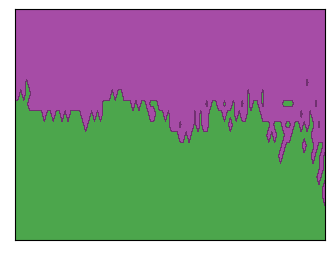

In [37]:
pred_new = model_list[2].predict(xnew)
pred_new_cl = np.argmax(pred_new, axis=1)
from matplotlib.colors import ListedColormap
colors = ('green', 'purple', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:2])
plt.figure(figsize=(4,3))
plt.contourf(np.repeat(pos_range[:,None],hi_range.size, axis=1)+pos_min, 
             np.repeat(hi_range[None,:],pos_range.size, axis=0), 
             pred_new_cl.reshape([pos_range.size,hi_range.size]), levels=[160,200,285], alpha=0.7, cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.ylim(0.22, 0.33)
#plt.savefig('../figures/cnn6_164_281.pdf', bbox_inches='tight')
plt.show()

In [38]:
pred_new_cl

array([164, 164, 164, ..., 281, 281, 281])

103/103 [==============================] - 2s 18ms/step


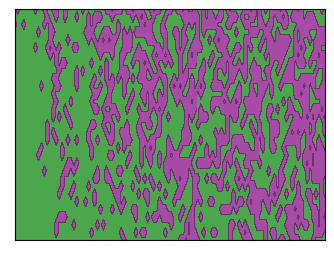

In [39]:
pred_new = model_list[0].predict(xnew)
pred_new_cl = np.argmax(pred_new, axis=1)
plt.figure(figsize=(4,3))
plt.contourf(np.repeat(pos_range[:,None],hi_range.size, axis=1)+pos_min, 
             np.repeat(hi_range[None,:],pos_range.size, axis=0), 
             pred_new_cl.reshape([pos_range.size,hi_range.size]), levels=[160,200,285], alpha=0.7, cmap=cmap)
plt.xticks([])
plt.yticks([])
#plt.savefig('../figures/cnn2_164_281.pdf', bbox_inches='tight')
plt.show()

103/103 [==============================] - 9s 87ms/step


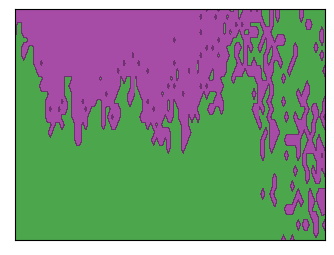

In [40]:
pred_new = model_list[6].predict(xnew)
pred_new_cl = np.argmax(pred_new, axis=1)
plt.figure(figsize=(4,3))
plt.contourf(np.repeat(pos_range[:,None],hi_range.size, axis=1)+pos_min, 
             np.repeat(hi_range[None,:],pos_range.size, axis=0), 
             pred_new_cl.reshape([pos_range.size,hi_range.size]), levels=[160,200,285], alpha=0.7, cmap=cmap)
plt.xticks([])
plt.yticks([])
#plt.savefig('../figures/inc6_164_281.pdf', bbox_inches='tight')
plt.show()

In [34]:
plt.rcParams.update({'font.size': 12})

In [35]:
miscl = np.array([])
for i, p in enumerate(preds):
    if i == 0:
        miscl = np.unique(get_misclassification_pairs(p, ye), axis=0)
    else:
        miscl = np.vstack([miscl, np.unique(get_misclassification_pairs(p, ye), axis=0)])
miscl = np.unique(miscl, axis=0)

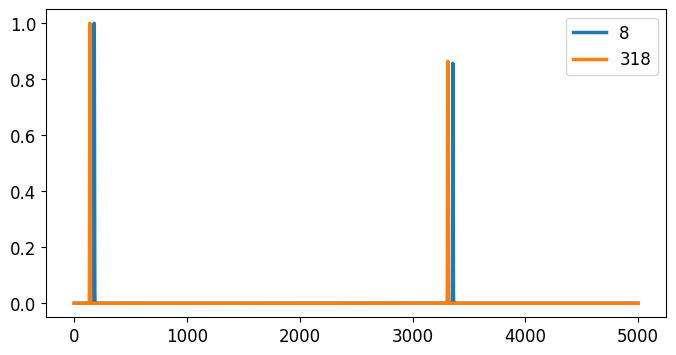

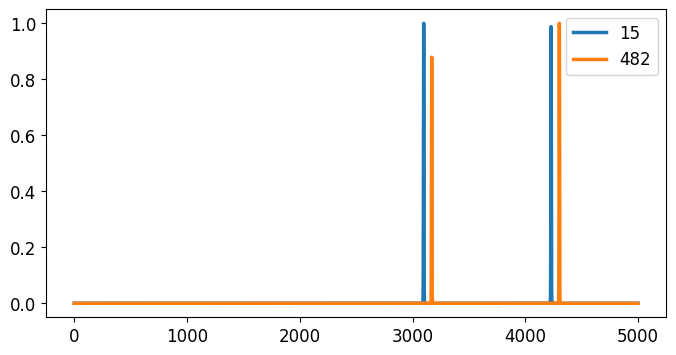

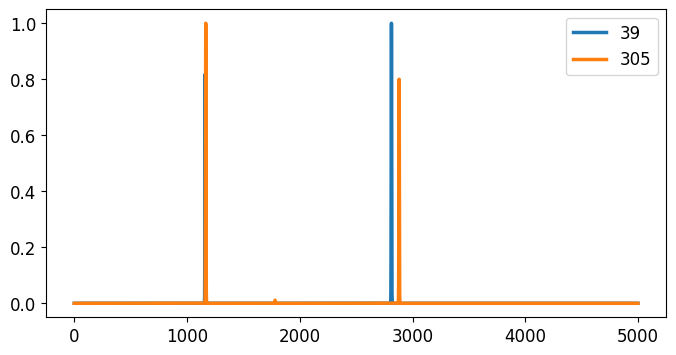

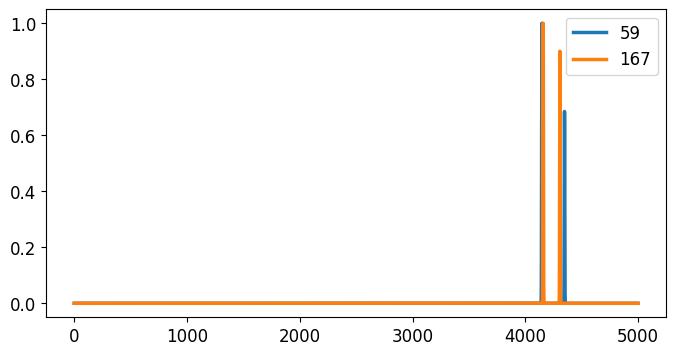

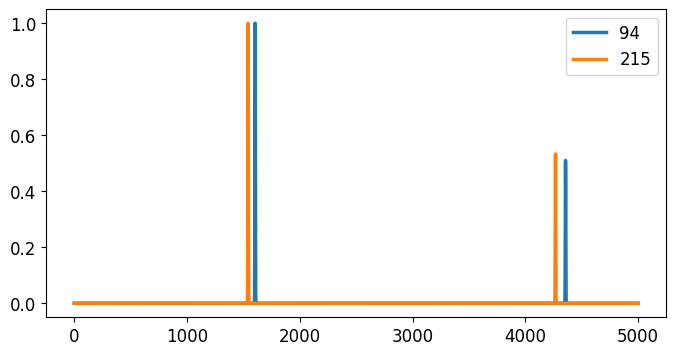

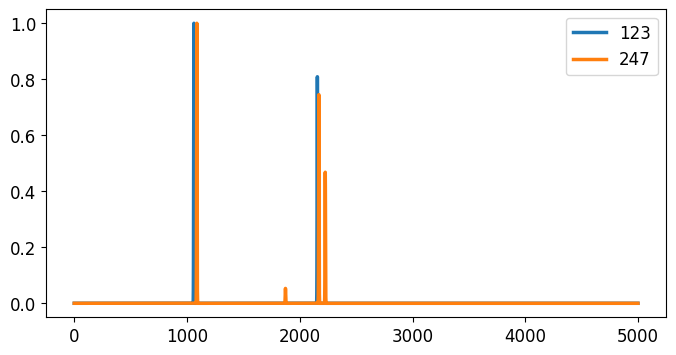

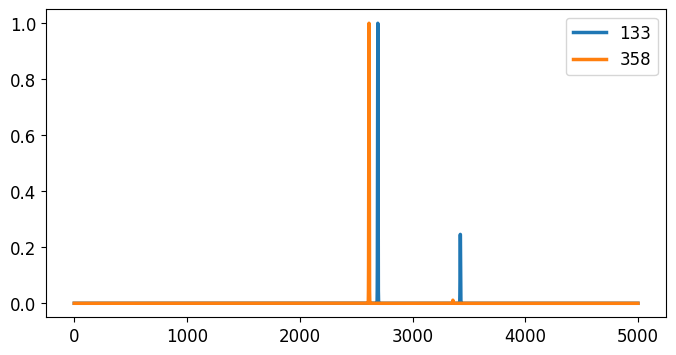

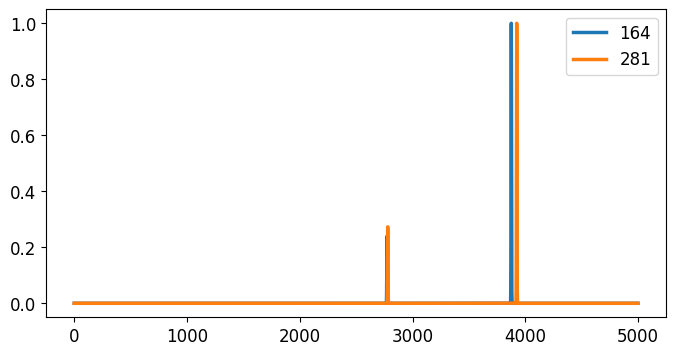

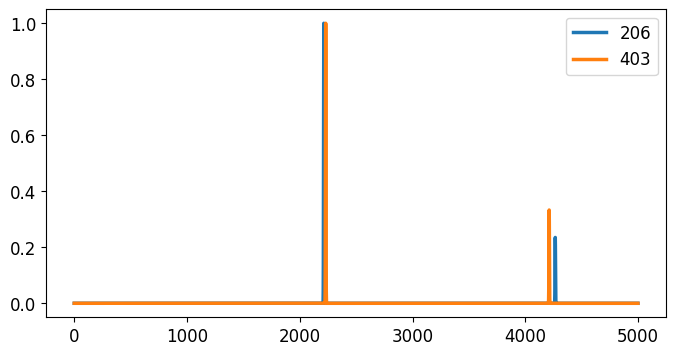

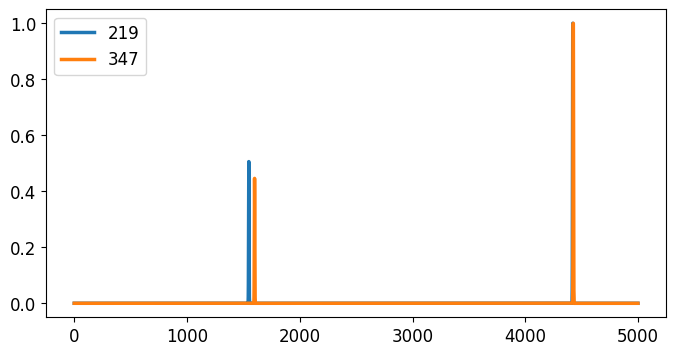

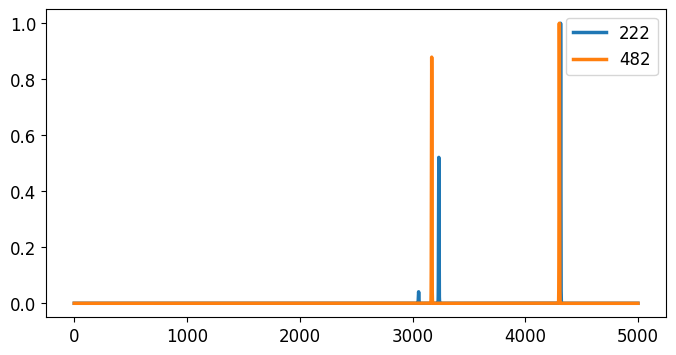

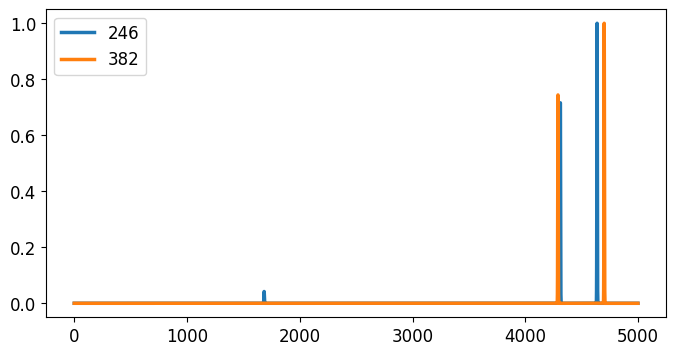

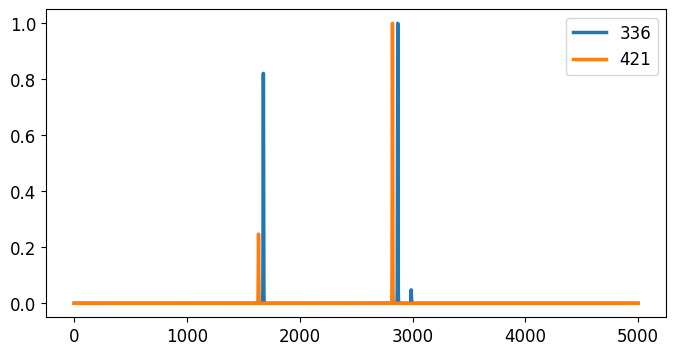

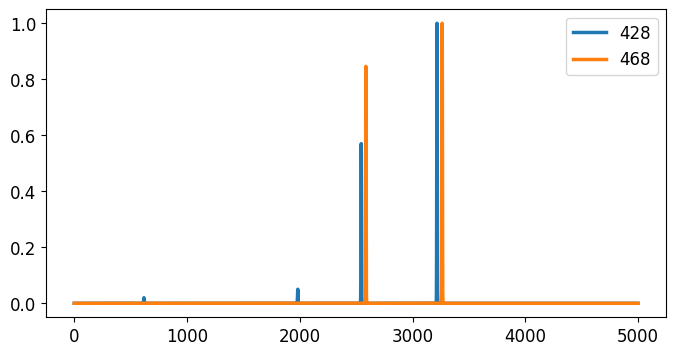

In [36]:
for miscl_idx in range(miscl.shape[0]):
    miscl1,miscl2 = miscl[miscl_idx]
    plt.figure(figsize=(8,4))
    plt.plot(xp[miscl1], lw=2.5, label=str(miscl1))
    plt.plot(xp[miscl2], lw=2.5, label=str(miscl2))
    plt.legend()
    plt.show()